In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from datetime import datetime, timedelta, date
from collections import OrderedDict
import subprocess
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

plotting.style(var_length=20)

In [3]:
freqdata = frequency.information(data,period_format="year")
freqdata = frequency.distribution(freqdata,metadata_selectors=["speech_member_party"])
freqdata = frequency.normalization(freqdata,'/media/ruben/Elements/PhD/data/hansard/resources/character_counts_year_pm.csv')
freqdata = freqdata[freqdata['speech_member_party'].isin(['Conservative','Labour'])].reset_index(drop=True)

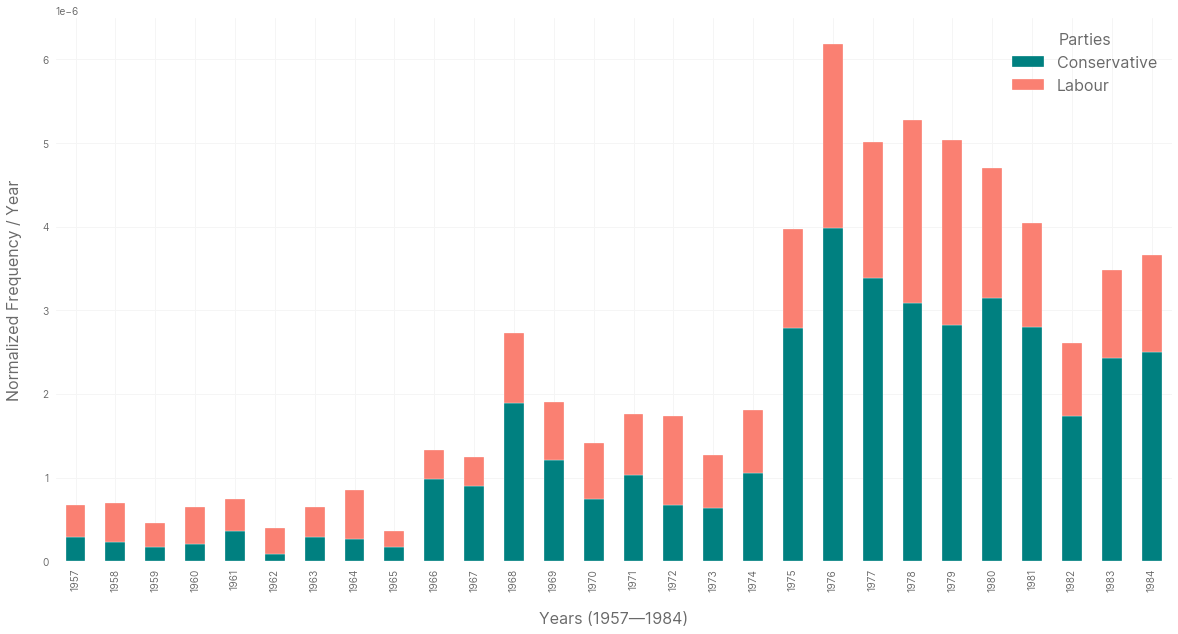

In [73]:
# Plot Relative Frequency per Party, stacked

freqdata_ = freqdata.pivot(index='date',columns='speech_member_party',values='bureaucracy_hits').reset_index().fillna(0.0)

fig, ax = plt.subplots()
freqdata_.plot.bar(x='date',y=list(freqdata_.columns)[1:],figsize=(20,10),stacked=True,color=['teal','salmon'],ax=plt.gca())
plt.xlabel("Years (1957—1984)",labelpad=20)
plt.ylabel("Normalized Frequency / Year",labelpad=20)
ax.legend(title="Parties",fontsize=16)
plt.savefig("/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/freq-bureaucracy-rel-bar-party.png",dpi=450)
plt.show()

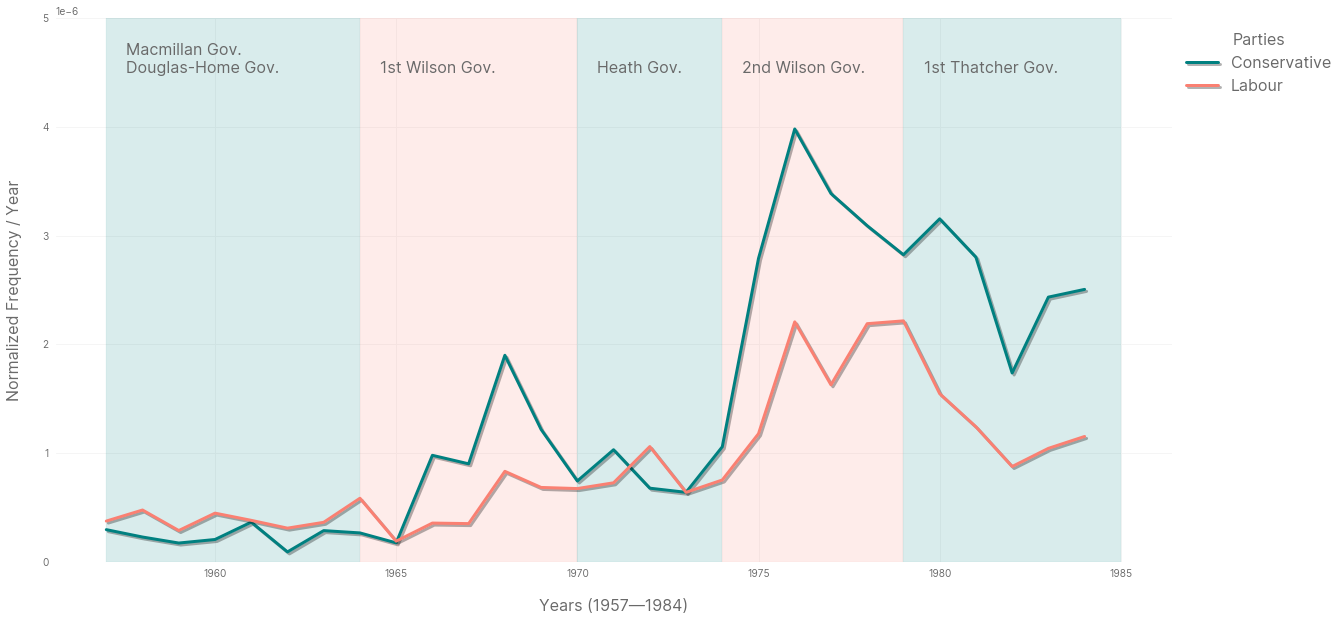

In [83]:
# freqdata_['Total'] = freqdata_['Conservative'] + freqdata_['Labour']
# freqdata_['Conservative'] = freqdata_['Conservative'] / freqdata_['Total']
# freqdata_['Labour'] = freqdata_['Labour'] / freqdata_['Total']
# freqdata_ = freqdata_.drop('Total',axis=1)

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(freqdata_['date'], freqdata_['Conservative'],color='teal',linewidth=3,path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])
plt.plot(freqdata_['date'], freqdata_['Labour'],color='salmon',linewidth=3,path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])

freqdata_['date'] = freqdata_['date'].astype(int)
plt.xlabel("Years (1957—1984)",labelpad=20)
plt.ylabel("Normalized Frequency / Year",labelpad=20)
ax.legend(labels=['Conservative','Labour'], title="Parties",fontsize=16,bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(0,0.000005)
for x in [['Macmillan Gov. \nDouglas-Home Gov.',1957,1964,"teal"],["1st Wilson Gov.",1964,1970,"salmon"],["Heath Gov.",1970,1974,"teal"],["2nd Wilson Gov.",1974,1979,"salmon"],["1st Thatcher Gov.",1979,1985,"teal"]]:
    ax.axvspan(x[1], x[2], alpha=0.15, color=x[3])
    ax.text(x[1] + (abs(ax.get_xlim()[0]-ax.get_xlim()[1]) / 55),ax.get_ylim()[1] - (abs(ax.get_ylim()[0]-ax.get_ylim()[1]) / 10), x[0], fontsize=16)

plt.savefig("/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/freq-bureaucracy-annotated-line-party.png",dpi=450)
plt.show()

In [ ]:
# Absolute Frequency 'Quango' compared / party
d = pd.DataFrame()

def get(word,year):
    grp = f'egrep -iE "{word}"  /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*{year}*'
    output = subprocess.check_output(grp,shell=True).decode('utf-8')
    output = [l.split('\t') for l in output.split('\n')]
    d = pd.DataFrame(output).iloc[:,[0,8,9,11]]
    d.columns = "id name party text".split(' ')
    return d

for y in range(1977,1986):
    d = d.append(get("quango",y))

d = d.dropna().reset_index(drop=True)
d['id'] = d['id'].str.split('/').str[-1].str.split('.').str[3].str[:4].astype(int)
d['n'] = 1
d = d.groupby(['party','id']).sum().reset_index().pivot(index='id',columns='party',values='n').reset_index().fillna(0)[['id','Conservative','Labour']]

fig, ax = plt.subplots(figsize=(4,2))
d.plot.bar(x='id',y=['Conservative','Labour'],figsize=(20,10),stacked=False,color=['teal','salmon'],ax=plt.gca(),legend=False)
plt.xlabel("Years (1977—1985)",labelpad=20)
plt.ylabel("Frequency",labelpad=20)
plt.title("Number of Different Lab. & Con. Speakers using the lemma 'quango'")
plt.savefig("/home/ruben/Documents/GitHub/CrisisBureaucracy/results/freq-quango-party-comp.png",dpi=250)
plt.show()

In [6]:
# Formfilling, paperwork and red tape plots
freqdata = data_loader.subset(start_date=1957,end_date=1985,words="form filling,red tape,paper work,a bureaucracy,unnecessary bureaucracy,bureaucracy go mad".split(','))
freqdata = frequency.information(freqdata,period_format="year")
freqdata = frequency.distribution(freqdata,metadata_selectors=["speech_member_party"])
freqdata = frequency.normalization(freqdata,'/media/ruben/Elements/PhD/data/hansard/resources/character_counts_year_pm.csv')
freqdata = freqdata[freqdata['speech_member_party'].isin(['Conservative','Labour'])].reset_index(drop=True)

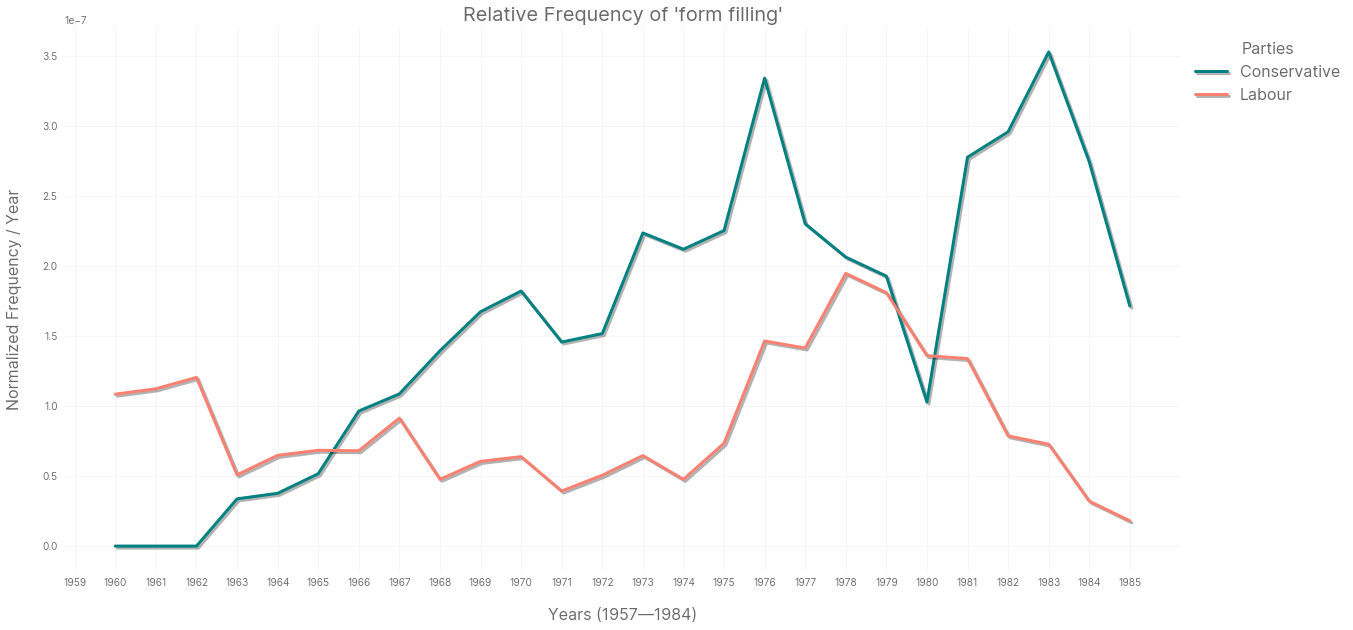

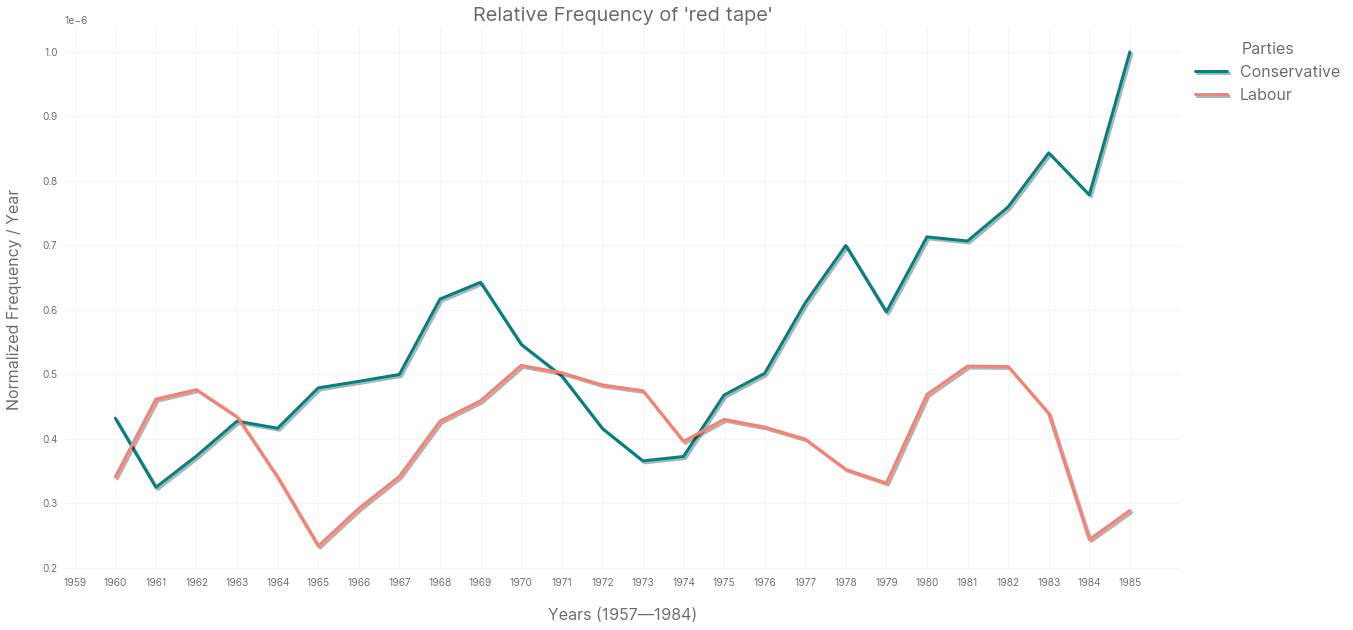

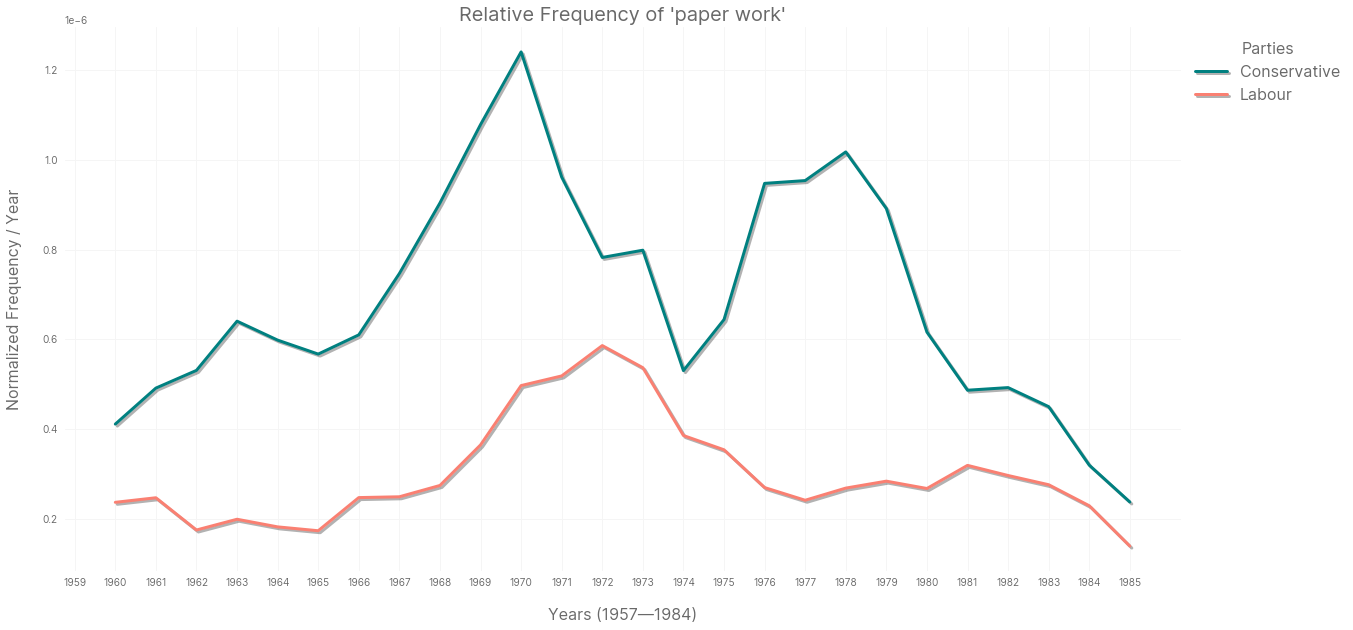

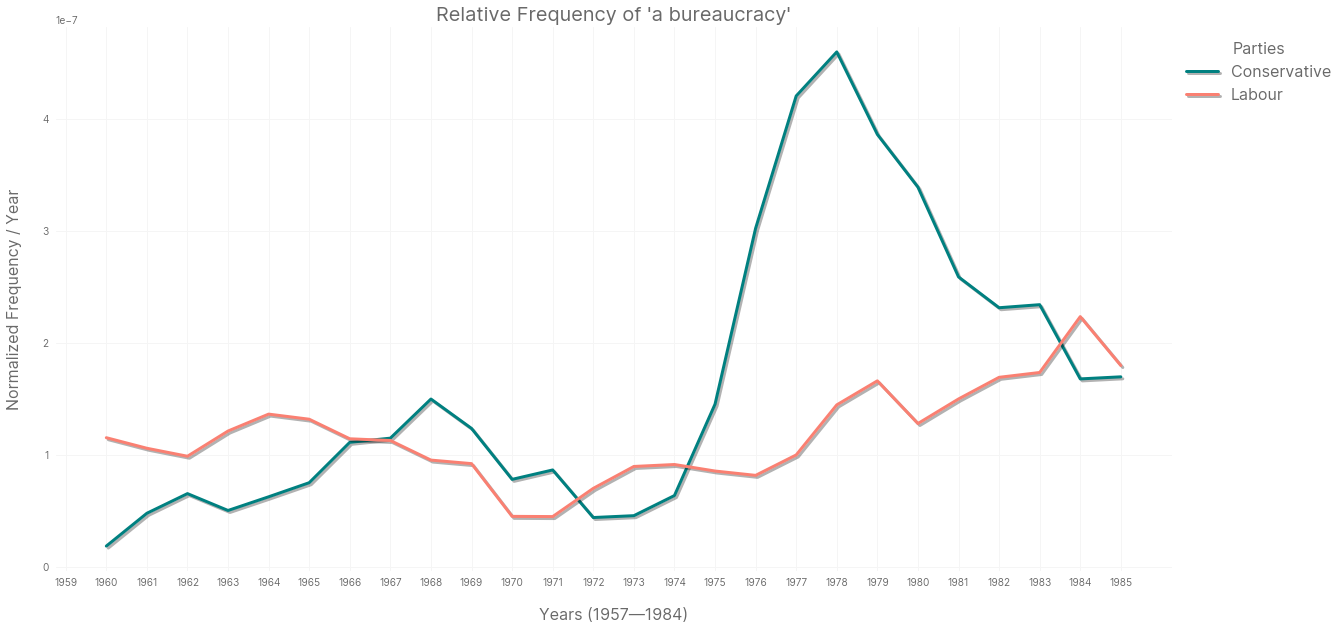

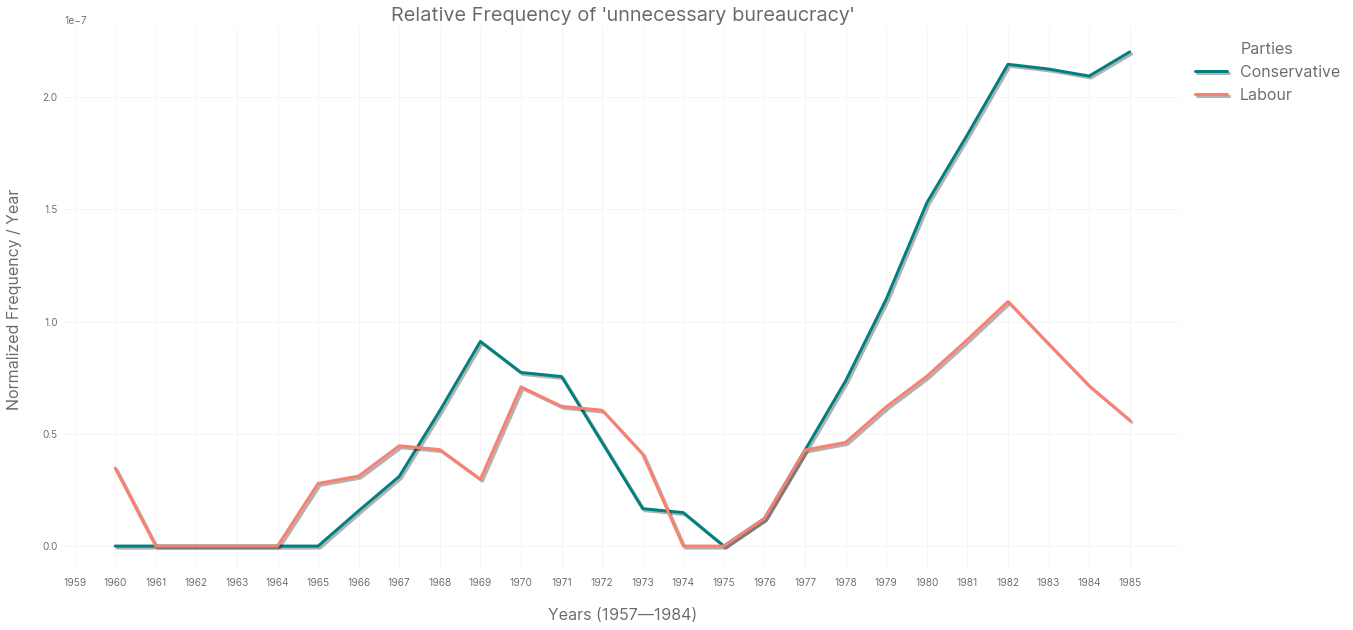

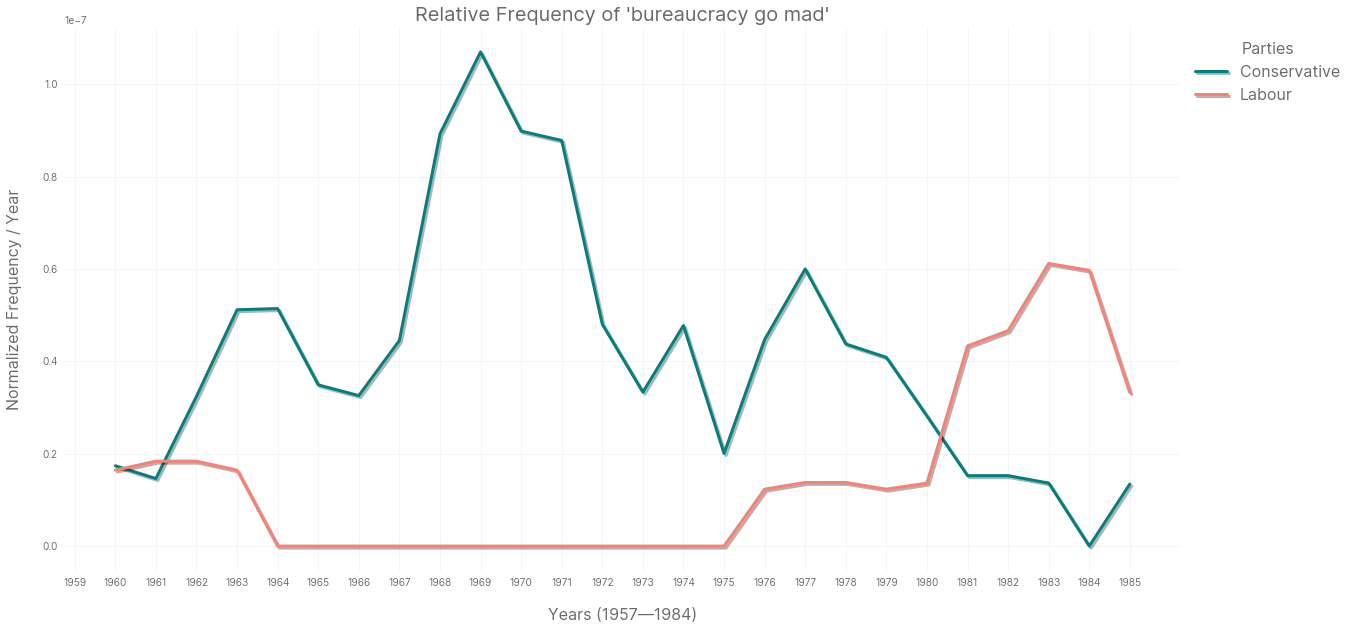

In [7]:
for ngram in "form filling,red tape,paper work,a bureaucracy,unnecessary bureaucracy,bureaucracy go mad".split(','):
    cl = ngram+"_hits"
    f = freqdata["date,speech_member_party".split(',') + [cl]]
    f = f.pivot(index='date',columns='speech_member_party',values=cl).reset_index()

    for c in ['Conservative','Labour']:
        f[c] = f[c].rolling(4, win_type='gaussian').sum(std=3)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(f['date'], f['Conservative'],color='teal',linewidth=3,path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])
    plt.plot(f['date'], f['Labour'],color='salmon',linewidth=3,path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])

    f['date'] = f['date'].astype(int)
    plt.xlabel("Years (1957—1984)",labelpad=20)
    plt.ylabel("Normalized Frequency / Year",labelpad=20)
    ax.legend(labels=['Conservative','Labour'], title="Parties",fontsize=16,bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f"Relative Frequency of '{ngram}'")
    plt.savefig(f"/home/ruben/Documents/GitHub/CrisisBureaucracy/results/freq-{ngram.replace(' ','')}-rel-bar-party.png",dpi=450, bbox_inches='tight')
    plt.show()

In [3]:
freqdata = data_loader.subset(start_date=1957,end_date=1985,words=['managerial'])
freqdata = frequency.information(freqdata,period_format="year")
freqdata = frequency.distribution(freqdata,metadata_selectors=["speech_member_party"])
freqdata = frequency.normalization(freqdata,'/media/ruben/Elements/PhD/data/hansard/resources/character_counts_year_pm.csv')
freqdata = freqdata[freqdata['speech_member_party'].isin(['Conservative','Labour'])].reset_index(drop=True)

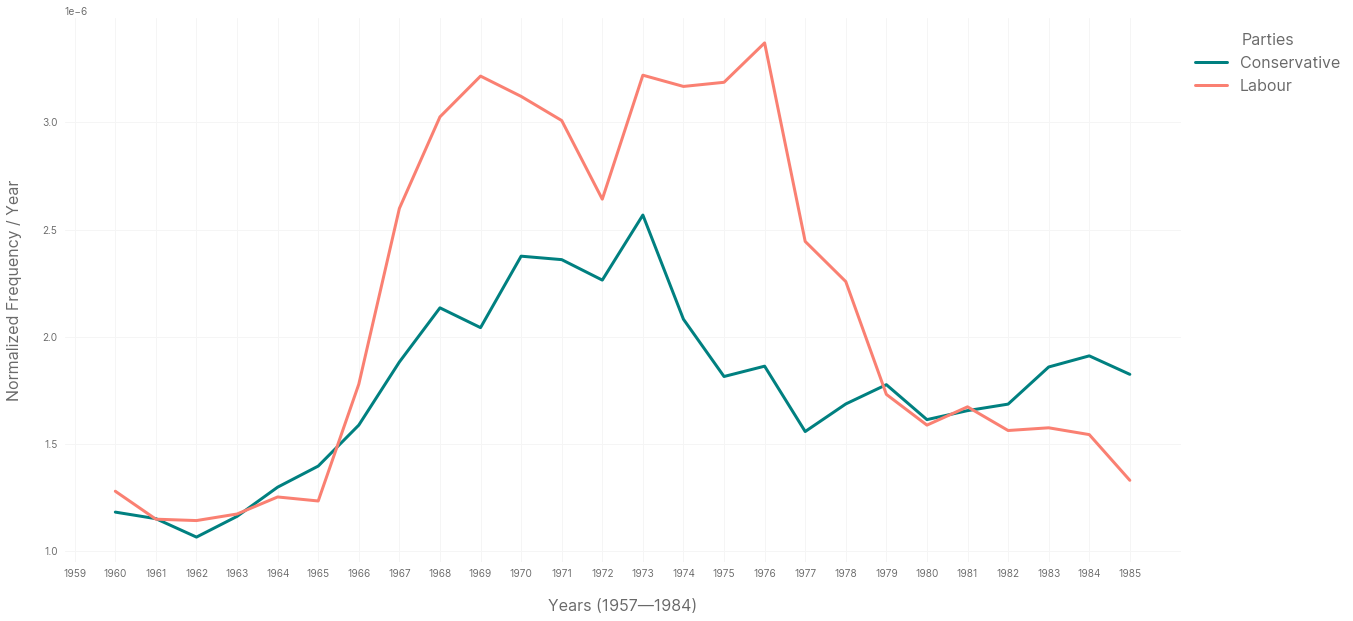

In [5]:
f = freqdata.pivot(index='date',columns='speech_member_party',values='managerial_hits').reset_index()

for c in ['Conservative','Labour']:
    f[c] = f[c].rolling(4, win_type='gaussian').sum(std=3)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(f['date'], f['Conservative'],color='teal',linewidth=3)
plt.plot(f['date'], f['Labour'],color='salmon',linewidth=3)

f['date'] = f['date'].astype(int)
plt.xlabel("Years (1957—1984)",labelpad=20)
plt.ylabel("Normalized Frequency / Year",labelpad=20)
ax.legend(labels=['Conservative','Labour'], title="Parties",fontsize=16,bbox_to_anchor=(1, 1), loc='upper left')
#plt.title(f"Relative Frequency of '{ngram}'")
#plt.savefig(f"/home/ruben/Documents/GitHub/CrisisBureaucracy/results/freq-{ngram.replace(' ','')}-rel-bar-party.png",dpi=450, bbox_inches='tight')
plt.show()